Titanic, Kaggle.     
This notebook is coded in Colab.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/yunseong3736/ML-DL/blob/main/Titanic_Kaggle.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Try it with Colab.</a>
  </td>
</table>

### Upload datesets and import

In [31]:
from google.colab import files
files.upload()
print("Complete")

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv
Complete


In [32]:
import pandas as pd
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

test_submission = test_data

### Data preprocessing



> #### Check data information



In [33]:
train_data.info()
print('-'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [34]:
# Looking at NaN %

nan = pd.DataFrame(train_data.isna().sum(), columns = ['NaN_Sum'])
nan['Per(%)'] = nan['NaN_Sum']/891 * 100
nan = nan[nan['NaN_Sum'] > 0]
nan

,NaN_Sum,Per(%)
Age,177,19.865320
Cabin,687,77.104377
Embarked,2,0.224467


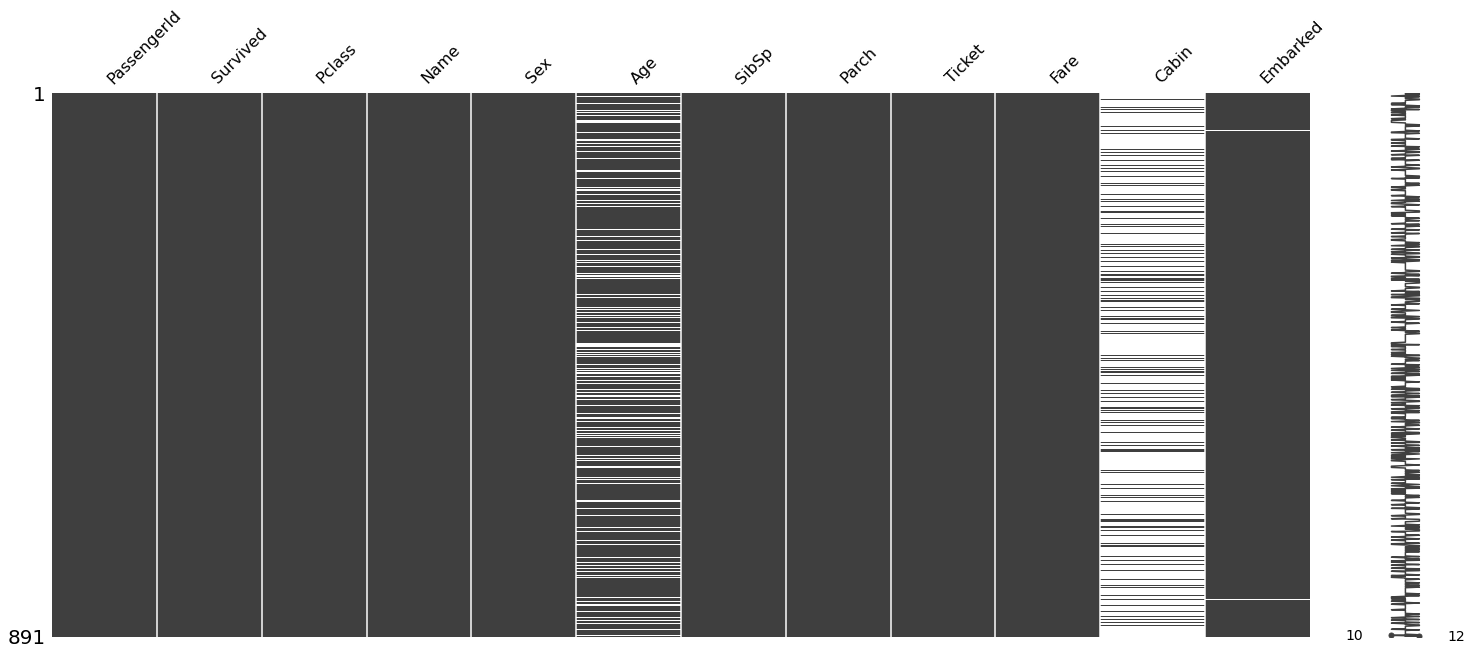

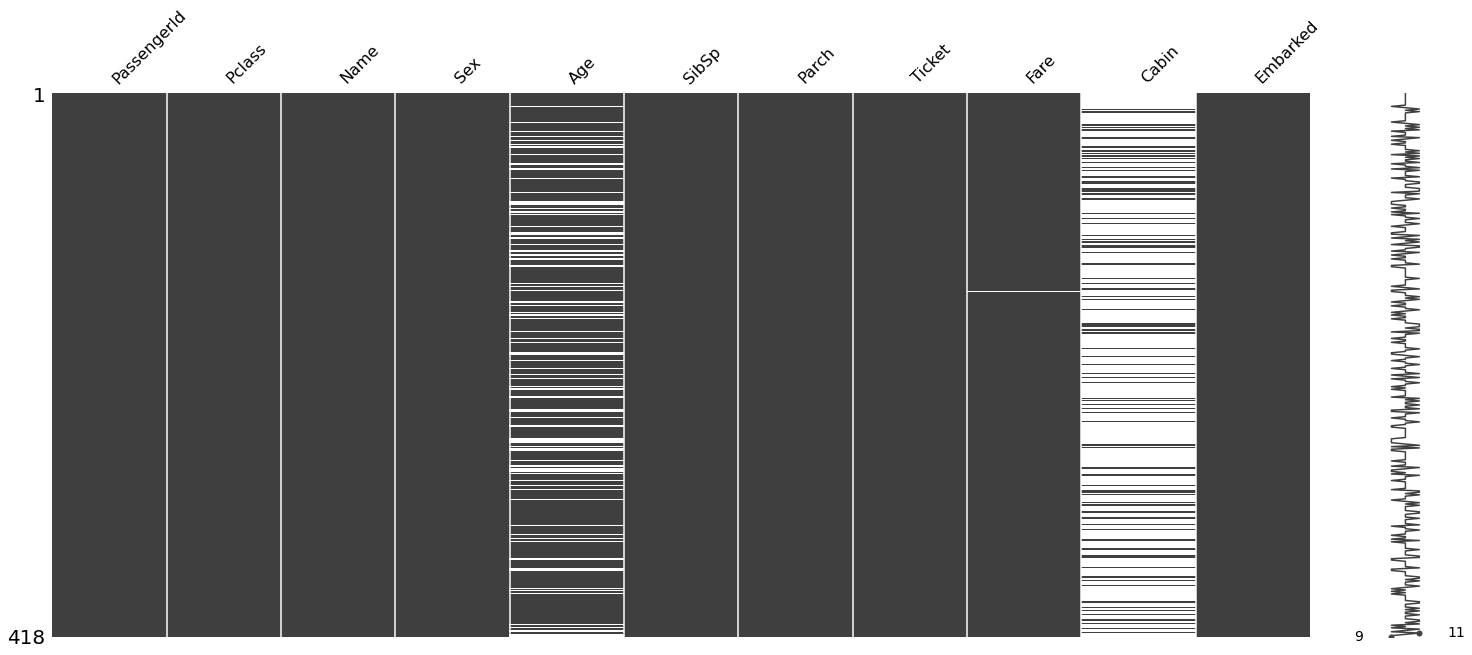

In [35]:
# Missing data in traing set by visualized matrix
import missingno

missingno.matrix(train_data)
missingno.matrix(test_data)

In [36]:
# Drop useless columns

train_data = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
test_data = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

In [37]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [38]:
print(train_data.isnull().sum())
print('-'*40)
print(test_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
----------------------------------------
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64




> #### Build pipeline and column transformer



In [39]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('Encode', OneHotEncoder())]
)

ct = ColumnTransformer([
                        ('numeric', SimpleImputer(strategy='median'),['Age','Fare']),
                        ('cat', cat_pipeline,['Pclass','Sex','Embarked'])],
                        remainder = 'passthrough'
)



> #### Get labels & Drop labels from training data





In [40]:
labels = train_data['Survived']
train_data = train_data.drop(['Survived'], axis = 1)

In [41]:
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


> #### Transform training data

In [42]:
train_data = ct.fit_transform(train_data)

In [43]:
train_data

array([[22.    ,  7.25  ,  0.    , ...,  1.    ,  1.    ,  0.    ],
       [38.    , 71.2833,  1.    , ...,  0.    ,  1.    ,  0.    ],
       [26.    ,  7.925 ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  0.    , ...,  1.    ,  1.    ,  2.    ],
       [26.    , 30.    ,  1.    , ...,  0.    ,  0.    ,  0.    ],
       [32.    ,  7.75  ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

### Modeling



> #### SVM



In [44]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = 'auto')
svm_clf.fit(train_data, labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, train_data, labels, cv=30)

In [46]:
svm_scores.mean()

0.7355555555555554

> #### RandomForestClassifier

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

rf_params ={
    'bootstrap': [True, False],
    'max_depth': [10, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100]}

rf_gs = GridSearchCV(rf_model, rf_params, scoring='accuracy', cv=8, n_jobs=4)

rf_gs.fit(train_data, labels)
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.8429757882882882


In [48]:
rf_clf = rf_gs.best_estimator_
rf_scores = cross_val_score(rf_clf, train_data, labels, cv=30)

In [49]:
rf_scores.mean()

0.8373180076628352

### Predicting with test data
### Do submission

In [50]:
test_data = ct.fit_transform(test_data)

In [51]:
pred_data = rf_clf.predict(test_data)

submission = pd.DataFrame({'PassengerId': test_submission.PassengerId, 'Survived': pred_data})
submission.to_csv('titanic_submission.csv', index = False)

In [52]:
files.download('titanic_submission.csv')
print("Complete")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Complete
